1、读入数据
2、先训练knn
3、训练bp神经网络
4、训练决策树
5、使用遗传算法,最后得到优化的参数
6、最后从最后的个体中，选取最优的21个个体，进行集成学习，进行幸福感预测
7、最后写报告整理资料、写课堂总结

#### 一、读入数据、数据预处理

In [1]:
# 导入相关的数据读入模块
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']

In [2]:
# 导入数据，解析survey_time列的值作为独立的日期列，指定字符集类型
train = pd.read_csv('./data/happiness_train_complete.csv', parse_dates=['survey_time'], encoding='latin-1')
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015-08-04 14:18:00,1,1959,1,...,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015-07-21 15:04:00,1,1992,1,...,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015-07-21 13:24:00,2,1967,1,...,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015-07-25 17:33:00,2,1943,1,...,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015-08-10 09:50:00,2,1994,1,...,2,50,50,50,50,50.0,50,50,50,50


In [3]:
# 查看数据的形态
train.shape

(8000, 140)

In [4]:
#查看所有的幸福度
o=set(train['happiness'])
print(o)

{1, 2, 3, 4, 5, -8}


In [5]:
# 处理异常值
# 将happiness中的‘-8’无法回答，改为‘3’说不上幸福不幸福
train['happiness'] = train['happiness'].replace(-8, 3)

In [6]:
# 判断是否包含缺失值
# isnull用于遍历dataframe每一个元素，将是空的元素置为True，将非空的元素置为False，sum用于计算每一列中为True元素的个数
train.isnull().sum()

id                         0
happiness                  0
survey_type                0
province                   0
city                       0
county                     0
survey_time                0
gender                     0
birth                      0
nationality                0
religion                   0
religion_freq              0
edu                        0
edu_other               7997
edu_status              1120
edu_yr                  1972
income                     0
political                  0
join_party              7176
floor_area                 0
property_0                 0
property_1                 0
property_2                 0
property_3                 0
property_4                 0
property_5                 0
property_6                 0
property_7                 0
property_8                 0
property_other          7934
                        ... 
m_political                0
m_work_14                  0
status_peer                0
status_3_befor

In [7]:
# loc[]方法用于实现将happiness=-8的行进行过滤，也就是保留hapiness不为-8的行，因为幸福指数只有1-5，-8明显是一个错误的读入值
train = train.loc[train['happiness'] != -8]

In [8]:
train.shape

(8000, 140)

In [9]:
train['happiness'].value_counts()

4    4818
5    1410
3    1171
2     497
1     104
Name: happiness, dtype: int64

In [10]:
# 使用.dt.year将survey_time转换成year的时间
train['survey_time'] = train['survey_time'].dt.year

In [11]:
# 通过birth和survey时间计算出接受采访者的年龄
train['Age'] = train['survey_time']-train['birth']

In [12]:
del_list=['survey_time','birth']
print(train['Age'])

0       56
1       23
2       48
3       72
4       21
5       69
6       52
7       56
8       63
9       30
10      27
11      47
12      51
13      76
14      80
15      32
16      41
17      53
18      39
19      50
20      64
21      67
22      35
23      73
24      59
25      45
26      49
27      52
28      23
29      68
        ..
7970    57
7971    20
7972    38
7973    39
7974    50
7975    43
7976    62
7977    67
7978    39
7979    31
7980    61
7981    69
7982    46
7983    62
7984    80
7985    45
7986    40
7987    52
7988    54
7989    84
7990    25
7991    43
7992    49
7993    61
7994    40
7995    34
7996    70
7997    48
7998    37
7999    24
Name: Age, Length: 8000, dtype: int64


In [13]:
'''
对dataframe中的数据进行简单的编码
小于16岁的为0；16-32的为1；32-48的为2；48-64的为3；64-80的为4；大于80的为5
'''
combine=[train]
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 80, 'Age'] = 5

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


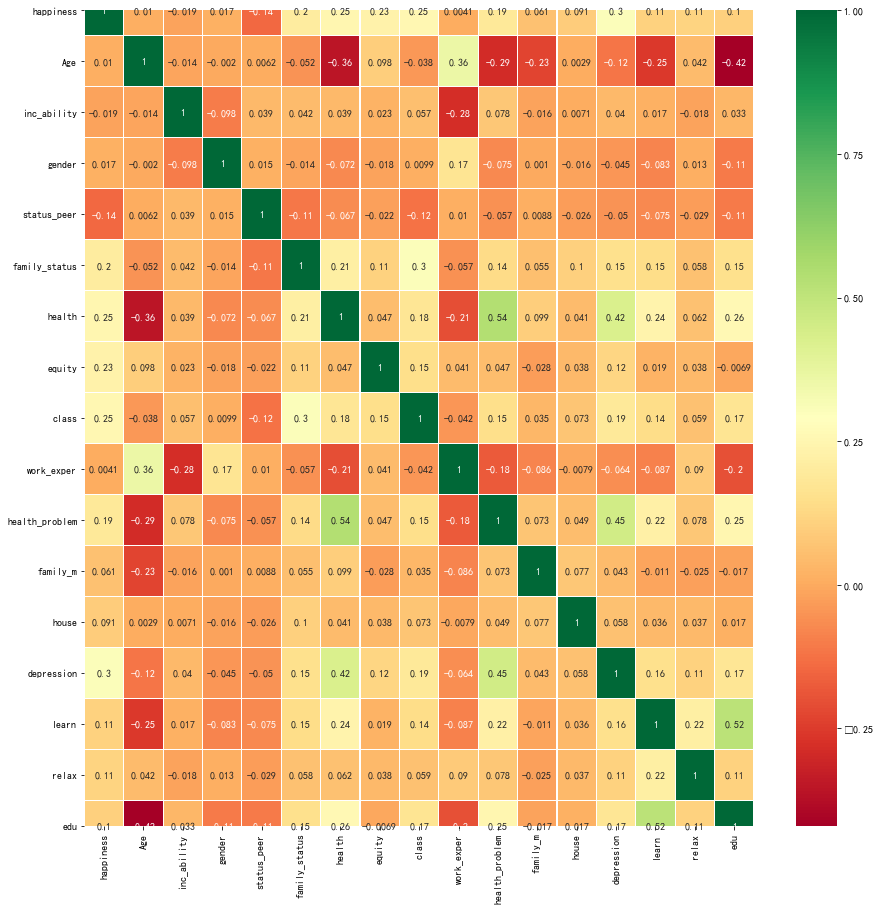

In [14]:
'''
绘制以下数据的热度图，
.corr()方法表示的是计算dataframe多个指标的相关系数矩阵，默认使用pearson计算方法
train[]表示传入热度图的数据，
annot（布尔类型），用于控制是否在个字中间标明数字，
cmap表示控制热度的渐变色，
linewidths表示每个单元格的线的宽度'''
sns.heatmap(train[['happiness','Age','inc_ability','gender','status_peer','family_status','health','equity','class','work_exper','health_problem','family_m','house','depression','learn','relax','edu']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()  #获取当前的图表和子图
fig.set_size_inches(15,15)  #设置图像的密集度：设置图像的长和宽
plt.show()

In [15]:
'''
最后选择的特征为Age年龄,inc_ability收入是否合理,gender性别,status_peer与同龄人相比的收入情况,work_exper工作经历及情况,family_status家庭年收入情况,health身体健康状况,equity认为社会是否公平,class认为应该处于的社会阶层,health_problem影响健康的程度,family_m家庭人数,house拥有房产数量,depression压力沮丧程度,learn是否学习充电,relax休闲放松,edu教育程度
'''
features=['Age','inc_ability','gender','status_peer','work_exper','family_status','health','equity','class','health_problem','family_m','house','depression','learn','relax','edu']

In [16]:
# 设置训练模型参数，target为模型输出的标签项，train为模型输入，test为测试集数据
# 特征工程完成得到最后用于训练和测试的数据集
train_target = train['happiness']
train = train[features]

### 二、数据测试集和训练集划分及归一化

In [17]:
# 进行数据随机划分模块
from sklearn.model_selection import train_test_split 
# 进行数据标准化
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
standardScaler.fit(train)
train_transform = standardScaler.transform(train)
X_train,X_test,Y_train,Y_test = train_test_split(train_transform,train_target,test_size=0.3)

### 三、训练knn模型

In [18]:
# 先引入进行评估的相关的包
from sklearn import metrics    


In [19]:
from sklearn.neighbors import KNeighborsClassifier
test_knn = KNeighborsClassifier(n_neighbors = 5,p = 2,weights = 'distance')
test_knn.fit(X_train,Y_train)
Y_predict_train = test_knn.predict(X_test)
print(metrics.accuracy_score(Y_test,Y_predict_train),"%")

0.5591666666666667 %


### 四、训练BP神经网络模型

In [20]:
# MLPClassifier() BP神经网络
# 查看文章：https://blog.csdn.net/weixin_42348202/article/details/100568469
from sklearn.neural_network import MLPClassifier   

In [21]:
bp = MLPClassifier(hidden_layer_sizes=(50,50),max_iter=100)
bp.fit(X_train,Y_train)
Y_bp_predict = bp.predict(X_test)
print(metrics.accuracy_score(Y_test,Y_bp_predict),"%")

0.5870833333333333 %


E:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 五、训练决策树模型

In [22]:
# 导入需要的块
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7,min_samples_split=4)
tree.fit(X_train,Y_train)
Y_tree_predict = tree.predict(X_test)
print(metrics.accuracy_score(Y_tree_predict,Y_test),"%")

0.595 %


### 六、使用遗传算法，进行进化学习，得到每个决策分类模型中表现较好的7个参数模型，得到一共21个模型，最后进行集成投票的原则得到更好的分类结果。

In [23]:
# 定义一些全局变量，方便变异操作
# 所有模型对应的范围
# knn模型对应的范围
knn_n_neighbors_min = 5
knn_n_neighbors_max = 30
knn_p_min = 1
knn_p_max = 6
# bp神经网络模型参数对应范围
bp_iter_min = 100
bp_iter_max = 300
bp_x_min = 10
bp_x_max = 50
bp_y_min = 10
bp_y_max = 50
# 决策树模型参数对应的范围
tree_depth_min = 5
tree_depth_max = 15
tree_split_min = 2
tree_split_max = 8
#迭代的次数：
epoches = 200
# 相应的分类器集合和参数集合，设置为全局变量
knn_set = []
bp_set = []
tree_set = []
knn_param_set = []
bp_param_set = []
tree_param_set = []

#### 1、确定初始群体，进行初始化

In [24]:
def init():
    #knn初始化群体
    for n_neighbors in range(5,31,2):
        for p in range(1,6,1):
            knn_set.append(KNeighborsClassifier(n_neighbors =n_neighbors ,p = p))
            knn_param_set.append([n_neighbors,p])
    for max_iter in range(100,300,20):
        for x in range(10,51,5):
            for y in range(10,51,5):
                bp_set.append(MLPClassifier(hidden_layer_sizes=(x,y),max_iter=max_iter))
                bp_param_set.append([max_iter,x,y])
    for max_depth in range(5,15,1):
        for min_samples_split in range(2,8,1):
            tree_set.append(DecisionTreeClassifier(max_depth=max_depth,min_samples_split=min_samples_split))
            tree_param_set.append([max_depth,min_samples_split])
    return knn_set,bp_set,tree_set,knn_param_set,bp_param_set,tree_param_set

#### 2、选择，使用准确率作为评分依据得到累计概率

In [25]:
# 得到评分
def classfier_score(X,Y,classfier):
    classfier.fit(X, Y)
    pred = classfier.predict(X)
    return metrics.accuracy_score(y_true=Y, y_pred=pred)

# 计算每个个体的适应度,返回适应度圆盘，用于下一步轮盘赌原则用于选择个体
def adaption(X,Y,classfier_set):
    score = []
    for classfier in classfier_set:
        score.append(classfier_score(X,Y,classfier))
    sm = np.sum(score)
    ada = score / sm
    for i in range(1, len(ada)):
        ada[i] = ada[i] + ada[i - 1]
    return ada
                               
# 根据轮盘进行选择,得到对应的分类器和对应的分类参数
def choose_classfiers(classfier_set,classfier_param_set,ada):
    count = len(classfier_set)
    result = []
    result_param =[]
    for i in range(count):
        r = random.random()
        for j in range(len(ada)):
            if r<= ada[j]:
                result.append(classfier_set[j])
                result_param.append(classfier_param_set[j])
                break;
    return result,result_param                      

#### 3、交叉，使用的是参数的交叉，随机根据参数的位置进行，交叉

In [26]:
# 两个分类器参数之间的交叉，分类型进行不用类别的交叉,
def cross(index1,index2,type,param_set):
    if (type == "knn") or (type == "tree"):
        #随机产生0-1的数进行交叉
        index_temp = random.randint(0,1)
        data_temp = param_set[index1][index_temp]
        param_set[index1][index_temp] = param_set[index2][index_temp]
        param_set[index2][index_temp] = data_temp
    else:
        # 随机产生0-2的树进行交叉
        index_temp = random.randint(0,2)
        data_temp = param_set[index1][index_temp]
        param_set[index1][index_temp] = param_set[index2][index_temp]
        param_set[index2][index_temp] = data_temp
    return

# 整个集合的交叉也要传进来类型是什么，对于该集合的参数，每间隔三个个体进行随机交叉
def all_cross(classfier_set,type):
    set_len = len(classfier_set)
    # 最后交叉完的集合
    for i in range(1,set_len,3):
        cross(i,i-1,type,classfier_set)
    return

#### 4、变异，通过对参数进行操作达到变异的目的

In [27]:
# 分类型进行不同类别的变异，变异的范围还要进行自己的确认不能超出正常范围,变异率默认设置为0.2
# 就是简单的+1或者-1操作，当达到最大值时只能减，最小值时只能加，其他随意加减
def variation(classfier_set,type,probality):
    count = int(len(classfier_set)*probality)#变异的个数
    while count > 0:
        index_tep = random.randint(0,len(classfier_set))#每个分类器变异的位置
        operation = random.randint(0,1)#0减1加
        if type == 'knn':
            index_param = random.randint(0,1)#参数变异的位置
            if operation == 0:
                if index_param == 0:
                    if classfier_set[index_tep][0] == knn_n_neighbors_min:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                else:
                    if classfier_set[index_tep][1] == knn_p_min:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] + 1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] - 1
            else:#运算是加的情况
                if index_param == 0:
                    if classfier_set[index_tep][0] == knn_n_neighbors_max:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                else:
                    if classfier_set[index_tep][1] == knn_p_max:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] -1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] + 1
        elif type =="tree":
            index_param = random.randint(0,1)#参数变异的位置
            if operation == 0:
                if index_param == 0:
                    if classfier_set[index_tep][0] == tree_depth_min:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                else:
                    if classfier_set[index_tep][1] == tree_split_min:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] + 1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] - 1
            else:#运算是加的情况
                if index_param == 0:
                    if classfier_set[index_tep][0] == tree_depth_max:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                else:
                    if classfier_set[index_tep][1] == tree_split_max:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] -1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] + 1  
        else:#是神经网络模型的时候
            index_param = random.randint(0,2)#参数变异的位置
            if operation == 0:
                if index_param == 0:
                    if classfier_set[index_tep][0] == bp_iter_min:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                elif index_param == 1:
                    if classfier_set[index_tep][1] == bp_x_min:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] + 1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] - 1
                else:
                    if classfier_set[index_tep][2] == bp_y_min:
                        classfier_set[index_tep][2] = classfier_set[index_tep][2] + 1
                    else:
                        classfier_set[index_tep][2]= classfier_set[index_tep][2] - 1    
            else:#运算是加的情况
                if index_param == 0:
                    if classfier_set[index_tep][0] == bp_iter_max:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] -1
                    else:
                        classfier_set[index_tep][0] = classfier_set[index_tep][0] +1
                elif index_param == 1:
                    if classfier_set[index_tep][1] == bp_x_max:
                        classfier_set[index_tep][1] = classfier_set[index_tep][1] -1
                    else:
                        classfier_set[index_tep][1]= classfier_set[index_tep][1] + 1
                else:
                    if classfier_set[index_tep][2] == bp_y_max:
                        classfier_set[index_tep][2] = classfier_set[index_tep][2] - 1
                    else:
                        classfier_set[index_tep][2]= classfier_set[index_tep][2] + 1         
        count = count - 1    

In [28]:
# 更新相应的分类器参数后，继续根据参数，得到相应的分类器集合
def to_get_classfiers_set():
    new_knn_set = []
    new_bp_set = []
    new_tree_set = []
    for temp in knn_param_set:
        new_knn_set.append(KNeighbor,sClassifier(n_neighbors =temp[0] ,p = temp[1]))
    for temp1 in bp_param_set:
        new_bp_set.append(MLPClassifier(hidden_layer_sizes=(temp1[1],temp1[2]),max_iter=temp[0]))
    for temp2 in tree_param_set:
        new_tree_set.append(DecisionTreeClassifier(max_depth=temp2[0],min_samples_split=temp2[1]))
    return new_knn_set,new_bp_set,new_tree_set

#### 5、进化大约200次最后得到21个较优的个体，最后得到综合的分类器

In [29]:
# 迭代200次得到每个类别进化的个体集合，从每个集合选择准确率最高的7个
def to_get_best(knn_set,bp_set,tree_set):
    knn_best_set = set()
    bp_best_set = set()
    tree_best_set = set()
    min_score = 1#记录当前集合最小分数
    min_classfier = 0 #记录最小评估分数的分类器
    for i in range(0,7):
        for temp_classfier in knn_set:
            if len(knn_best_set) <= 7:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score < min_score:
                    min_classfier = temp_classfier 
                knn_best_set.add(temp_classfier)
            else:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score< min_score:
                    knn_best_set.remove(min_classfier)
                    knn_best_set.add(temp_classfier)
                    min_score = temp_score
        for temp_classfier in bp_set:
            if len(bp_best_set) <= 7:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score < min_score:
                    min_classfier = temp_classfier 
                bp_best_set.add(temp_classfier)
            else:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score< min_score:
                    bp_best_set.remove(min_classfier)
                    bp_best_set.add(temp_classfier)
                    min_score = temp_score
        for temp_classfier in tree_set:
            if len(knn_best_set) <= 7:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score < min_score:
                    min_classfier = temp_classfier 
                tree_best_set.add(temp_classfier)
            else:
                temp_score = classfier_score(X_train,X_test,temp_classfier)
                if temp_score< min_score:
                    tree_best_set.remove(min_classfier)
                    tree_best_set.add(temp_classfier)
                    min_score = temp_score
        the_end_set = set.union(knn_best_set,bp_best_set,tree_best_set)
    return the_end_set
        

In [30]:
#### 6、根据现在所有的模型，进行投票集成学习得到最后所有元素的分类，并且返回准确率
def to_ensemble(end_classfiers_set):
    y_label_predict = []
    for temp_data in X_test:
        predict_set = {}
        for classfiers in end_classfiers_set:
            classfiers.fit(X_train,Y_train)
            predict_set.append(classfiers.predict(temp_data))
            if classfiers not in predict_set.keys:
                predict_set[classfiers] = 1
            else:
                predict_set[classfiers] = predict_set[classfiers] + 1
        label = max(predict_set, key=predict_set.get)
        y_label_predict.append(label)
    return metrics.accuracy_score(y_label_predict,Y_test)

### 七、最后进行模型综合后，进行最后的评估

In [31]:
# 利用最后得到的最优的21个个体最终得到最后的模型
# 主函数入口
def main():
    #初始化
    global epoches
    knn_set,bp_set,tree_set,knn_param_set,bp_param_set,tree_param_set = init()
    while epoches > 0 :
        #选择
        ada1 = adaption(X_train,Y_train,knn_set)
        knn_set,knn_param_set = choose_classfiers(knn_set,knn_param_set,ada1)
        ada2 = adaption(X_train,Y_train,bp_set)
        bp_set,bp_param_set = choose_classfiers(bp_set,bp_param_set,ada2)
        ada3 = adaption(X_train,Y_train,tree_set)
        tree_set,tree_param_set = choose_classfiers(tree_set,tree_param_set,ada3)
        #交叉
        all_cross(knn_param_set,"knn")
        all_cross(bp_param_set,"bp")
        all_cross(tree_param_set,"tree")
        #变异
        variation(knn_param_set,"knn",0.2)
        variation(bp_param_set,"bp",0.2)
        variation(tree_param_set,"tree",0.2)
        #更新分类集合
        knn_set,bp_set,tree_set = to_get_classfiers_set()
        epoches = epoches -1 
    #得到综合分类器
    the_end_set = to_get_best(knn_set,bp_set,tree_set)
    accuracy = to_ensemble(the_end_set)
    print("准确率是：",accuracy)

In [ ]:
main()